# Customer Segmentation using simulated customer data of  Starbucks 

### Table of Contents:

1. Business Understanding
2. Data Understanding
3. Data Preperation
4. Explonatory Data Analysis (EDA)
5. Modeling & Evaluation
6. Discussion & Conclusion

### 1. Business Understanding

[Starbucks](https://www.starbucks.com) is an American multinational chain and is the world's largest coffeehouse chain. As of [September 2020](https://www.sec.gov/ix?doc=/Archives/edgar/data/829224/000082922420000078/sbux-20200927.htm), the company had 32,660 stores in 83 countries, including 16,637 company operated stores and 16,023 licensed stores.

Starbucks has a customer rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks and not all users receive the same offer. Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days.

The key business question to be answered through this project is ***Which demographic groups respond best to which offer type?***


**Assumptions**
- if an informational offer has 7 days of validity, it is assumed that the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

### 2. Data Understanding

This data set provided by [Udacity](https://www.udacity.com) for Data Scientist NanoDegree program contains simulated data that mimics customer behavior on the Starbucks rewards mobile app.

The data is contained in three files:
- portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
- profile.json - demographic data for each customer
- transcript.json - records for transactions, offers received, offers viewed, and offers completed

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
import progressbar

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler, TomekLinks, ClusterCentroids
from imblearn.over_sampling import SMOTE, RandomOverSampler
from lifetimes.utils import summary_data_from_transaction_data

import shap

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# define the constants

# color schemes for visuals
cl1 = '#47B39C'
cl2 = '#FFC154'
cl3 = '#EF767A'
cl4 = '#456990'

color_pal = [cl1, cl2, cl3, cl4]
sns.set_palette(sns.color_palette(color_pal))

# paths for the datasets
paths = {"portfolio_path": "data/portfolio.json",
        "profile_path": "data/profile.json",
         "transcript_path": "data/transcript.json"
        }

In [3]:
%run ./Project_dataprep_utils.ipynb

### 2.1 Portfolio Dataset

This contains offer ids and meta data about each offer (duration, type, etc.)
- id (string) - offer id
- offer_type (string) - type of offer ie BOGO, discount, informational
- difficulty (int) - minimum required spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) - time for offer to be open, in days
- channels (list of strings)

In [4]:
portfolio = pd.read_json(paths['portfolio_path'], orient='records', lines=True)
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [5]:
portfolio[portfolio['offer_type']=='bogo']

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d


BOGO deals: These are the deals where you buy one and receive one free. Validity will be 5 or 7 days, with two sorts of schemes offering various rewards for each period. All four schemes will be distributed via cellphone and email, with some also being disseminated via web or social media. What's interesting is that as the validity period gets shorter, more communication channels become involved. Because it's a buy one, get one free deal, the return for spending is 1:1.

In [6]:
portfolio[portfolio['offer_type']=='discount']

,reward,channels,difficulty,duration,offer_type,id
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


Discounts: These are for a longer validity term than bogo, which is either 7 or 10 days, and all schemes are communicated via online and email, with one scheme being highly communicated over four channels for each validity period. The one with the id "2298d6c36e964ae4a3e7e9706d1fb8c2 " has the highest return per difficulty.

In [7]:
portfolio[portfolio['offer_type']=='informational']

,reward,channels,difficulty,duration,offer_type,id
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837


There are 2 informational scheme with no offers which are communicated with email and mobile and either through web / social

### 2.2 Profile Dataset

This contains demographic data for each customer
- age (int) - age of the customer
- became_member_on (int) - date when customer created an app account
- gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
- id (str) - customer id
- income (float) - customer's income

In [8]:
profile = pd.read_json(paths['profile_path'], orient='records', lines=True)
profile.head(2)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0


In [9]:
profile.drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 796.9+ KB


This dataset contains 17K customer information and around 13% missing demographic data

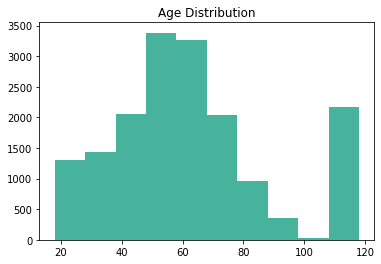

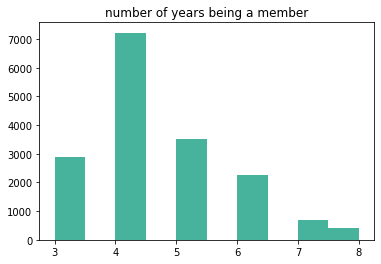

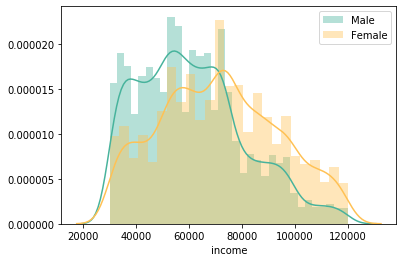

In [10]:
ax = plt.subplot()

plt.hist(profile.age, color = cl1)
plt.title('Age Distribution')
plt.show()

# # years of memebership uptodate
ax = plt.subplot()
profile.became_member_on = pd.to_datetime(profile.became_member_on, 
                                      format='%Y%m%d')
profile['years_member'] = round((pd.to_datetime('today') 
                              - profile['became_member_on'])
                              .astype('timedelta64[D]')
                              .astype(int)/365, 0)
plt.hist(profile.years_member, color = cl1)
plt.title('number of years being a member')
plt.show()

ax = plt.subplot()
sns.distplot(profile[profile.gender=='M'].income,label='Male')
sns.distplot(profile[profile.gender=='F'].income,label='Female')
plt.legend()
plt.show()

From the demographic data age clearly seems to have outliers

In [11]:
profile[["age"]].describe()

,age
count,17000.000000
mean,62.531412
std,26.738580
min,18.000000
25%,45.000000
50%,58.000000
75%,73.000000
max,118.000000


In [12]:
profile[profile["age"]==118][['gender', 'income']].drop_duplicates()

,gender,income
0,None,NaN


The records with outliers have missing values for gender and income. So for further analysis these will be dropped as  13% of records have missing/ outlier values for 3 columns

### 2.3 Transcript Data
- event (str) - record description (ie transaction, offer received, offer viewed, etc.)
- person (str) - customer id
- time (int) - time in hours since start of test. The data begins at time t=0
- value - (dict of strings) - either an offer id or transaction amount depending on the record



In [13]:
transcripts = pd.read_json(paths['transcript_path'], orient='records', lines=True)
transcripts.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


This dataset has the transaction history of the customer with time stamp. This has transaction amounts, offer recevied, viewed and completed time

### 3.Data Preprocessing

#### 3.1 Preprocess Profile data

In [14]:
# drop missing values as 13% missing values are common across gender, income and has outlier age va;ue
profile.dropna(inplace = True)

# create feature : registration year
profile.became_member_on = pd.to_datetime(profile.became_member_on, 
                                              format='%Y%m%d')
profile['year_joined'] = profile['became_member_on'].apply(lambda x: str(x.year))
# dummify gender variable
gender_dummies = profile['gender'].str.get_dummies().add_prefix('gender_')

# create profile master
profile = pd.concat([profile, gender_dummies], axis=1)
profile.rename(columns = {'id': 'cust_id'}, inplace = True)
profile.head(2)

,gender,age,cust_id,became_member_on,income,years_member,year_joined,gender_F,gender_M,gender_O
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,4.0,2017,1,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,4.0,2017,1,0,0


#### 3.2 Preprocess portfolio data

In [15]:
portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)

#### 3.3 Preprocess transactoins data

In [16]:
# process transaction data - dummify
event_dummies = transcripts['event'].str.get_dummies()
event_dummies.drop('transaction', axis=1, inplace=True)
transcript = pd.concat([transcripts, event_dummies], axis=1)
transcript.rename(columns={'offer completed': 'offer_completed', 
                           'offer received': 'offer_received', 
                           'offer viewed': 'offer_viewed',
                          'person': 'cust_id'}, inplace=True)

In [17]:
# split transaction data and offers
transactions = transcript.query('event == "transaction"').copy()
transactions['amount'] = transactions['value'].apply(lambda x: list(x.values())[0])
transactions.drop(['value', 'offer_completed', 'offer_received', 'offer_viewed'], axis=1, inplace=True)
transactions.drop(['event'], axis=1, inplace=True)

offers = transcript.query('event != "transaction"').copy()
offers['offer_id'] = offers['value'].apply(lambda x: list(x.values())[0])
offers.drop(['value'], axis=1, inplace=True)
# add offer information
offers = offers.merge(portfolio, on = 'offer_id')

#### 3.4 create customer offer dataframe

In [18]:
cust_offer_received_count = (offers[offers['event']=='offer received']
                              .groupby(['cust_id', 'offer_type'])['event']
                              .count()).reset_index()

cust_offer_received_pivot = pd.pivot_table(cust_offer_received_count,
                                           values = ['event'], 
                                           index=['cust_id'], 
                                           columns = 'offer_type').reset_index().fillna(0)
cust_offer_received_pivot.rename(columns = {'event': 'event_count'}, inplace = True)
cust_offer_received_pivot = flatten_multiindex_colnames(cust_offer_received_pivot)
cust_offer_received_pivot.rename(columns = {'cust_id_': 'cust_id'}, inplace = True)
cust_offer_received_pivot['tot_count_offers_received'] = (cust_offer_received_pivot['event_count_bogo']
                                                         + cust_offer_received_pivot['event_count_discount']
                                                         + cust_offer_received_pivot['event_count_informational'])
cust_offer_received_pivot.head(3)

,cust_id,event_count_bogo,event_count_discount,event_count_informational,tot_count_offers_received
0,0009655768c64bdeb2e877511632db8f,1.0,2.0,2.0,5.0
1,00116118485d4dfda04fdbaba9a87b5c,2.0,0.0,0.0,2.0
2,0011e0d4e6b944f998e987f904e8c1e5,1.0,2.0,2.0,5.0


#### 3.4 calculate success

If a customer viewed an offer before ingesting it, he or she was considered a success for discounts and BOGO. For informational offers, it is determined whether they completed a transaction after receiving the advertisement within the validity period provided in the portfolio data.

In [19]:
# calculate offer success
cust_success_bogo_disc = get_success_flag_cust_offer_disc_bogo(offers)
cust_success_bogo_disc.drop('cust_offer_success_bogo_disc', axis = 1, inplace = True)
trx_info_success = calculate_informational_success(offers, transcript)
trx_info_success.drop('cust_offer_success_info', axis = 1, inplace = True)
# collate the 2 dataframes
offer_success_df = pd.concat([cust_success_bogo_disc, trx_info_success])
offer_success_df['sucess_flag'] = 1
offer_success_df = (offer_success_df.
                    merge(portfolio[['offer_id', 'offer_type']], on = 'offer_id')
                   )

In [20]:
# calculate customer level success
cust_success_df_agg = (offer_success_df
                        .groupby(['cust_id', 'offer_type'])['sucess_flag']
                              .sum()).reset_index()
cust_success_df_agg = pd.pivot_table(cust_success_df_agg,
                                           values = ['sucess_flag'], 
                                           index=['cust_id'], 
                                           columns = 'offer_type').reset_index().fillna(0)
cust_success_df_agg = (flatten_multiindex_colnames(cust_success_df_agg))
cust_success_df_agg.rename(columns = {'cust_id_': 'cust_id'}, inplace = True)
cust_success_df_agg['sucess_flag_bogo'] = np.where(cust_success_df_agg['sucess_flag_bogo'] >0,1,0)
cust_success_df_agg['sucess_flag_discount'] = np.where(cust_success_df_agg['sucess_flag_discount'] >0,1,0)
cust_success_df_agg['sucess_flag_informational'] = np.where(cust_success_df_agg['sucess_flag_informational'] >0,1,0)
cust_success_df_agg['tot_success'] = np.where((cust_success_df_agg['sucess_flag_bogo'] + 
                                             cust_success_df_agg['sucess_flag_discount'] +
                                             cust_success_df_agg['sucess_flag_informational'])>0, 1, 0)


#### 3.5 calculate RFM (Rececny, Frequency and Monetary values)

In [21]:
transactions['datetime'] = transactions['time'].apply(lambda x: pd.Timestamp('2020-01-01T12') + pd.Timedelta(hours=x))
rf = summary_data_from_transaction_data(transactions, 'cust_id', 'datetime', monetary_value_col='amount').reset_index()
rf.drop('T', axis=1, inplace=True)

#### 3.6 customer level master

In [22]:
cust_master = (profile
               # add rfm data to the model
              .merge(rf, on = 'cust_id', how = 'left')
               # fill null values in rfm by -1 as for the classification models it would be easy to classify
              .fillna(-1)
               .merge(cust_success_df_agg, on = 'cust_id', how = 'left')
               .merge(cust_offer_received_pivot, on = 'cust_id', how = 'left')
               # fill the success flags and count offers received by 0
               .fillna(0)
              )

In [23]:
cust_master.head()

,gender,age,cust_id,became_member_on,income,years_member,year_joined,gender_F,gender_M,gender_O,...,recency,monetary_value,sucess_flag_bogo,sucess_flag_discount,sucess_flag_informational,tot_success,event_count_bogo,event_count_discount,event_count_informational,tot_count_offers_received
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,4.0,2017,1,0,0,...,21.0,27.750000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,4.0,2017,1,0,0,...,16.0,24.320000,1.0,0.0,0.0,1.0,3.0,0.0,1.0,4.0
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,3.0,2018,0,1,0,...,10.0,18.420000,1.0,0.0,0.0,1.0,1.0,2.0,1.0,4.0
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,4.0,2018,0,1,0,...,22.0,13.445000,1.0,1.0,0.0,1.0,4.0,2.0,0.0,6.0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,4.0,2017,0,1,0,...,15.0,4.433333,0.0,1.0,0.0,1.0,0.0,2.0,1.0,3.0


### 4. Explonatory Data Analysis

#### 4.1 Gender level success rates

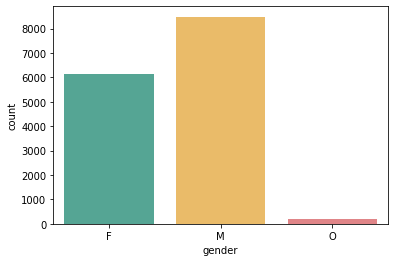

In [24]:
sns.countplot(x='gender', data=cust_master)

More customers are males and others ("O") are negligible

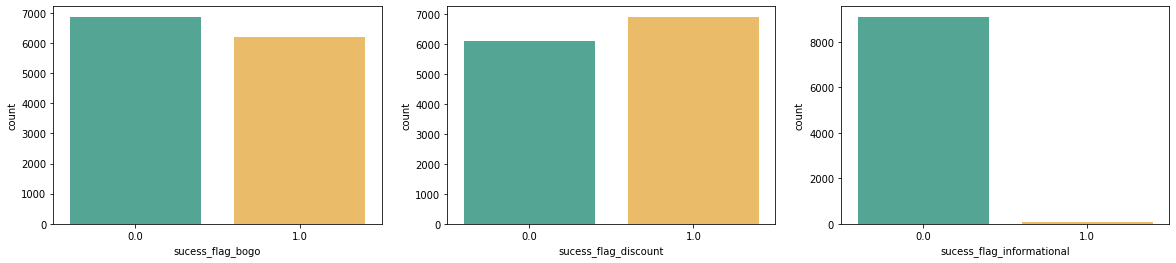

In [25]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 4))
sns.countplot(x='sucess_flag_bogo', 
              data=cust_master[cust_master['event_count_bogo']>0]
             , ax = axs[0])
sns.countplot(x='sucess_flag_discount', 
              data=cust_master[cust_master['event_count_discount']>0]
             , ax = axs[1])
sns.countplot(x='sucess_flag_informational', 
              data=cust_master[cust_master['event_count_informational']>0]
             , ax = axs[2])

Very low level of succes in informational offers but BOGO and discount offers have slight differences.

Text(0, 0.5, '')

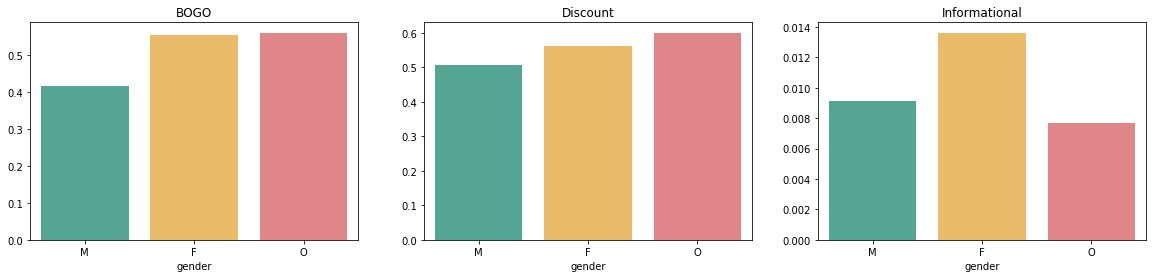

In [26]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 4))
ax = sns.barplot('gender',
                 y='sucess_flag_bogo', 
                 data=cust_master.query('event_count_bogo >0'), 
                 ci=None,
                 order=["M", "F", "O"],
                  ax=axs[0])
ax.set(title='BOGO')
ax.set_ylabel('')   
ax = sns.barplot('gender', 
                 y='sucess_flag_discount', 
                 data=cust_master.query('event_count_discount >0'), 
                 ci=None,
                 order=["M", "F", "O"],
                ax=axs[1])
ax.set(title='Discount')
ax.set_ylabel('')
ax = sns.barplot('gender',
                 y='sucess_flag_informational', 
                 data=cust_master.query('event_count_informational >0'), 
                 ci=None,
                 order=["M", "F", "O"],
                ax=axs[2])
ax.set(title='Informational')
ax.set_ylabel('')

Across all offers females seems to be more attracted towards offers

#### 4.2 Age level success rates

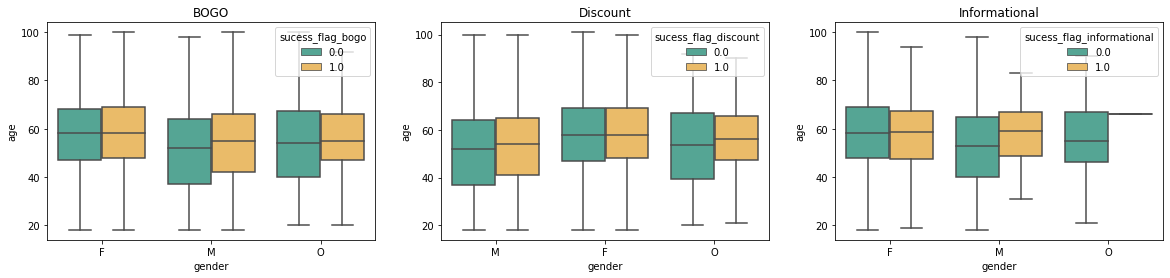

In [27]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 4))
plot_box_plots_bi_level_multiple(cust_master, 'age', 'gender', 'sucess_flag_bogo', 'event_count_bogo >0', axs[0], 'BOGO')
plot_box_plots_bi_level_multiple(cust_master, 'age', 'gender', 'sucess_flag_discount', 'event_count_discount >0', axs[1], 'Discount')
plot_box_plots_bi_level_multiple(cust_master, 'age', 'gender', 'sucess_flag_informational', 'event_count_informational >0', axs[2], 'Informational')

Mean Age doesnt seems to be changed much across successful and unsuccessful offers in all groups, although there is a slight chance of successful people to have higher mean age, very slightly

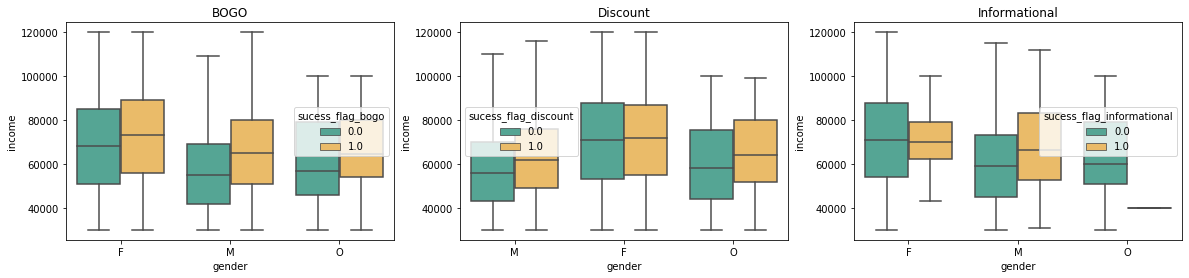

In [28]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 4))
plot_box_plots_bi_level_multiple(cust_master, 'income', 'gender', 'sucess_flag_bogo', 'event_count_bogo >0', axs[0], 'BOGO')
plot_box_plots_bi_level_multiple(cust_master, 'income', 'gender', 'sucess_flag_discount', 'event_count_discount >0', axs[1], 'Discount')
plot_box_plots_bi_level_multiple(cust_master, 'income', 'gender', 'sucess_flag_informational', 'event_count_informational >0', axs[2], 'Informational')

Except in informational offers for females in other groups mean income isslightly higher for the succeful offers

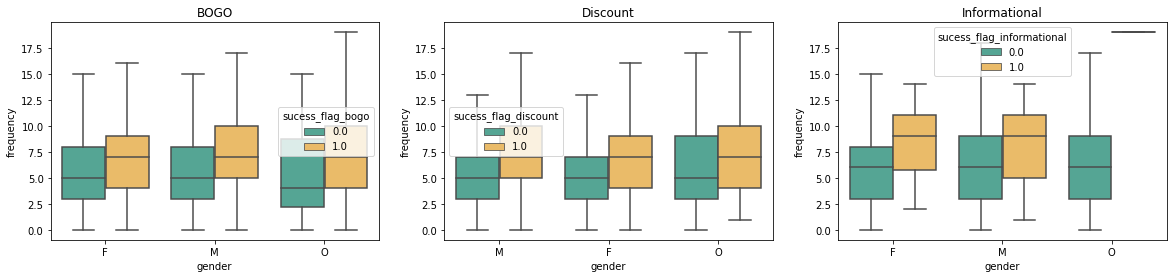

In [29]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 4))
plot_box_plots_bi_level_multiple(cust_master[cust_master['frequency']>=0],
                                 'frequency', 'gender', 'sucess_flag_bogo', 'event_count_bogo >0', axs[0], 'BOGO')
plot_box_plots_bi_level_multiple(cust_master[cust_master['frequency']>=0], 
                                 'frequency', 'gender', 'sucess_flag_discount', 'event_count_discount>0', axs[1], 'Discount')
plot_box_plots_bi_level_multiple(cust_master[cust_master['frequency']>=0], 
                                 'frequency', 'gender', 'sucess_flag_informational', 'event_count_informational >0', axs[2], 'Informational')

Except in informational offer in other groups high frequency customers have higher mean success

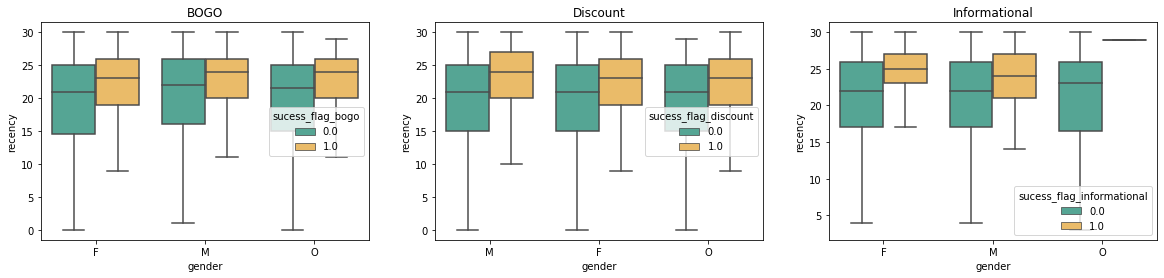

In [30]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 4))
plot_box_plots_bi_level_multiple(cust_master[cust_master['recency']>=0],
                                 'recency', 'gender', 'sucess_flag_bogo', 'event_count_bogo >0', axs[0], 'BOGO')
plot_box_plots_bi_level_multiple(cust_master[cust_master['recency']>=0], 
                                 'recency', 'gender', 'sucess_flag_discount', 'event_count_discount>0', axs[1], 'Discount')
plot_box_plots_bi_level_multiple(cust_master[cust_master['recency']>=0], 
                                 'recency', 'gender', 'sucess_flag_informational', 'event_count_informational >0', axs[2], 'Informational')

More recent customers seem to have  higher success

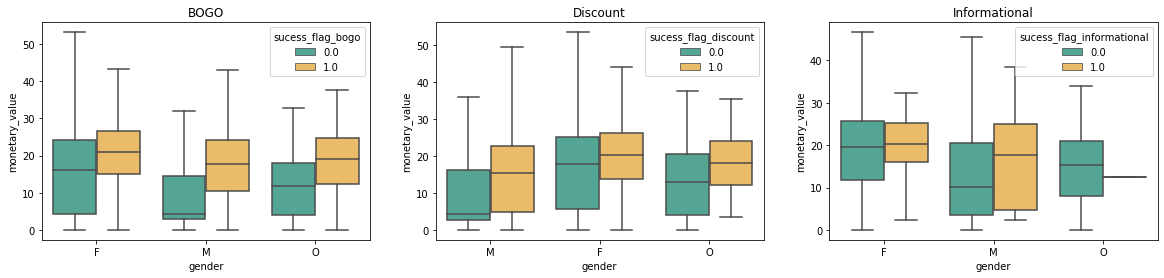

In [31]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 4))
plot_box_plots_bi_level_multiple(cust_master[cust_master['monetary_value']>=0],
                                 'monetary_value', 'gender', 'sucess_flag_bogo', 'event_count_bogo >0', axs[0], 'BOGO')
plot_box_plots_bi_level_multiple(cust_master[cust_master['monetary_value']>=0], 
                                 'monetary_value', 'gender', 'sucess_flag_discount', 'event_count_discount>0', axs[1], 'Discount')
plot_box_plots_bi_level_multiple(cust_master[cust_master['monetary_value']>=0], 
                                 'monetary_value', 'gender', 'sucess_flag_informational', 'event_count_informational >0', axs[2], 'Informational')

Higher spend customers seem to have more success

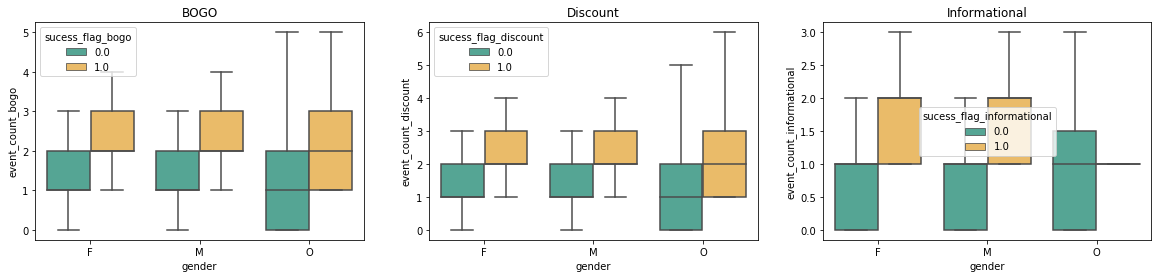

In [32]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 4))
plot_box_plots_bi_level_multiple(cust_master,
                                 'event_count_bogo', 'gender', 'sucess_flag_bogo', 'age >0', axs[0], 'BOGO')
plot_box_plots_bi_level_multiple(cust_master, 
                                 'event_count_discount', 'gender', 'sucess_flag_discount', 'age>0', axs[1], 'Discount')
plot_box_plots_bi_level_multiple(cust_master, 
                                 'event_count_informational', 'gender', 'sucess_flag_informational', 'age >0', axs[2], 'Informational')

universally customers who are receiving more discount offers, seems to have more success, that means more and more offers are received their is higher chance for them to accept them, However this might only be due to chance

#### 4.3 Correlation Analysis

In [33]:
demo_corr = ['gender', 'age', 'income',
       'years_member', 
       'frequency', 'recency', 'monetary_value', 'sucess_flag_bogo',
       'sucess_flag_discount', 'sucess_flag_informational', 'tot_success',
       'event_count_bogo', 'event_count_discount', 'event_count_informational',
       'tot_count_offers_received']

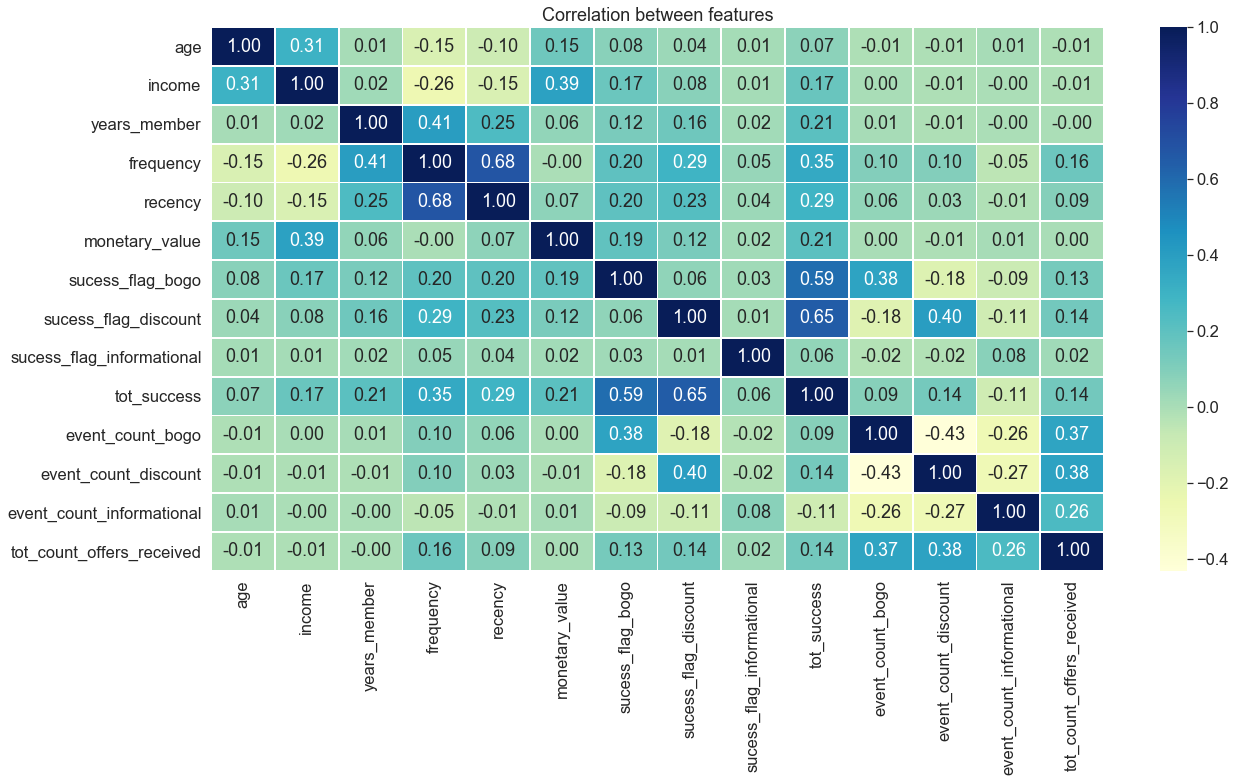

In [34]:
get_corrleation_plot(cust_master[demo_corr], True)

Not high significant correlation can be seen across features

### 5. Modeling

We will go with a classification model to evaluate the significant features which aids to classify the successful offers

In [35]:
# informational offers
y_var = 'sucess_flag_informational'
df = cust_master[cust_master['event_count_informational']>0]
df[y_var].value_counts(), df[y_var].value_counts()[1]/(df[y_var].value_counts()[0] + df[y_var].value_counts()[1])

(0.0    9099
 1.0     101
 Name: sucess_flag_informational, dtype: int64,
 0.010978260869565217)

It was noted during the EDA phase, the success rate of informational offers is quite low (only around 1% of total informational offers received clients), therefore we'll leave that out of the scope of the project until we have additional data to analyze.

The data will be trained across four different types of base models, including decision tree, random forest, gradient bossing, and ada boost models, and then tuned to produce better outcomes, if required.

In [36]:
# base models to compare through
dt_model = DecisionTreeClassifier(random_state = 9005)
rf_model = RandomForestClassifier(random_state=9005)
gb_model = GradientBoostingClassifier(random_state=9005)
ab_model = AdaBoostClassifier(random_state=9005)

#### 5.1 Model BOGO offer success

In [37]:
y_var = 'sucess_flag_bogo'
x_var = ['age', 'income',
       'years_member', 'gender_F', 'gender_M', 'gender_O',
       'frequency', 'recency', 'monetary_value',
        
       ]
df = cust_master[cust_master['event_count_bogo']>0]
df[y_var].value_counts(), df[y_var].value_counts()[1]/df[y_var].value_counts()[0]

cust_master[y_var].value_counts(), cust_master[y_var].value_counts()[1]/cust_master[y_var].value_counts()[0]

(0.0    8611
 1.0    6214
 Name: sucess_flag_bogo, dtype: int64,
 0.7216351178724887)

When looked at BOGO offers only, we do not see any class imbalance problem

In [38]:
y = cust_master[[y_var]]
x = cust_master[x_var]
X_train, X_test, y_train, y_test = get_train_test_split(x,y)


run_models_v2([dt_model, rf_model, gb_model,  ab_model],
              X_train, y_train, X_test, y_test, y_var, 
              print_res = False)

,DecisionTreeClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
dataframe_name,[sucess_flag_bogo],[sucess_flag_bogo],[sucess_flag_bogo],[sucess_flag_bogo]
training_score,0.999916,0.999916,0.709106,0.69882
testing_score,0.605396,0.670826,0.691737,0.691737
training_fscore_class_0,0.999928,0.999928,0.737123,0.727245
testing_fscore_class_0,0.658095,0.711584,0.718075,0.715442
training_fscore_class_1,0.999899,0.999899,0.674405,0.66378
testing_fscore_class_1,0.533493,0.616654,0.65997,0.663723


Without pruning all the models seems to overfit to the data as training score is higher while test core is very low. I will go with gradient boost as train test results are closer and not much overfitting issue is visible

In [39]:
gb_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 9005,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [40]:
# model tuning
y = df[[y_var]]
x = df[x_var]
gb_model = GradientBoostingClassifier(random_state=9005)
X_train, X_test, y_train, y_test = get_train_test_split(x,y)
parameters = {
    "n_estimators":[50, 100, 250],
    "max_depth":[3,5,7],
    "learning_rate":[0.01, 0.1]
}
cv = GridSearchCV(gb_model,parameters,cv=3)
cv_res = cv.fit(X_train, y_train.values.ravel())

In [41]:
cv.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}

In [42]:
display(cv)

Best parameters are: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


0.717 + or -0.002 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.72 + or -0.002 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
0.719 + or -0.002 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
0.711 + or -0.004 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
0.715 + or -0.001 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
0.716 + or -0.002 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 250}
0.707 + or -0.004 for the {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50}
0.71 + or -0.001 for the {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100}
0.709 + or -0.002 for the {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 250}
0.717 + or -0.004 for the {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
0.718 + or -0.005 for the {'learning_rate': 0.1, 'max

GradientBoostingClassifier trained on 10465 samples.
MSE_train: 0.2761
MSE_test: 0.2702
Training accuracy: 0.7239
Test accuracy: 0.7298
              precision    recall  f1-score   support

         0.0     0.7713    0.6770    0.7211      1350
         1.0     0.6955    0.7861    0.7381      1267

    accuracy                         0.7298      2617
   macro avg     0.7334    0.7316    0.7296      2617
weighted avg     0.7346    0.7298    0.7293      2617



{'dataframe_name': ['bogo'],
 'training_score': 0.7239369326325849,
 'testing_score': 0.7298433320596103,
 'training_fscore_class_0': 0.7221313840530922,
 'testing_fscore_class_0': 0.7211045364891517,
 'training_fscore_class_1': 0.7257191683281116,
 'testing_fscore_class_1': 0.738051130048166}

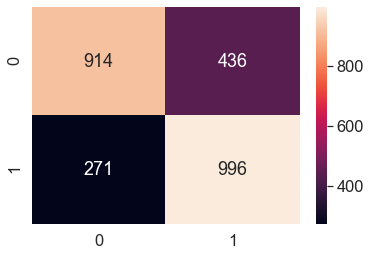

In [43]:
gb_model_bogo = GradientBoostingClassifier(random_state=9005,
                                          learning_rate =  0.01,
                                           max_depth = 3,
                                           n_estimators = 100)
predict_evaluate_model_v2(gb_model_bogo, X_train, y_train, X_test, y_test, 'bogo', True, True)

with a gradient boosting model with parameters {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100} we can get a model with around 72% accuracy and F score in both train and test sets.

In [44]:
clf_bogo = gb_model_bogo.fit(X_train, y_train)

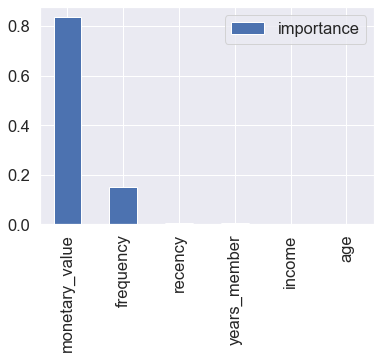

,importance
monetary_value,0.835649
frequency,0.152440
recency,0.004938
years_member,0.004768
income,0.001924
age,0.000281


In [45]:
get_feature_importance(clf_bogo, x, plot= True)

The success rate of BOGO offers seems to be affected by RFM features, membership period, income, and age. Customers' spending and frequency of visits appear to be the most essential factors among them.

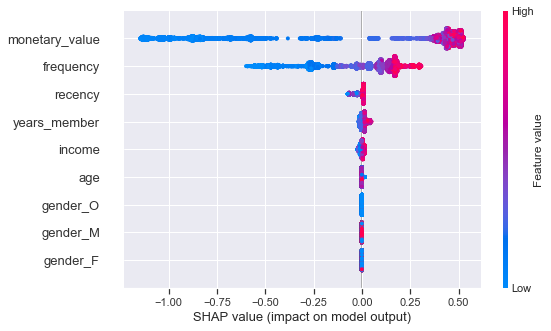

In [46]:
# shap analysis
clf_bogo = gb_model_bogo.fit(X_train, y_train)
X_train_df = pd.DataFrame(X_train, columns = x.columns)
explainer_bogo = shap.TreeExplainer(clf_bogo)
shap_values_bogo = explainer_bogo.shap_values(X_train_df)
shap.summary_plot(shap_values_bogo, features=X_train_df, feature_names=X_train_df.columns)

It appears that the bigger the amount spent, the frequency with which the customer shops, or the number of years being a member, the better chance of a offer being a success.

#### 5.3 Model Discount offer success

In [47]:
y_var = 'sucess_flag_discount'
df = cust_master[cust_master['event_count_discount']>0]
df[y_var].value_counts(), df[y_var].value_counts()[1]/df[y_var].value_counts()[0]

(1.0    6921
 0.0    6121
 Name: sucess_flag_discount, dtype: int64,
 1.1306975984316288)

In [48]:
y = df[[y_var]]
x = df[x_var]
X_train, X_test, y_train, y_test = get_train_test_split(x,y)


run_models_v2([dt_model, rf_model, gb_model,  ab_model],
              X_train, y_train, X_test, y_test, y_var, 
              print_res = False)

,DecisionTreeClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
dataframe_name,[sucess_flag_discount],[sucess_flag_discount],[sucess_flag_discount],[sucess_flag_discount]
training_score,1.0,0.999904,0.706221,0.693185
testing_score,0.596397,0.656573,0.68992,0.68417
training_fscore_class_0,1.0,0.999897,0.634989,0.635546
testing_fscore_class_0,0.572473,0.598206,0.616769,0.627823
training_fscore_class_1,1.0,0.99991,0.75419,0.735082
testing_fscore_class_1,0.617786,0.700134,0.73962,0.725699


Without pruning all the models (specislly the decision tree model) seems to overfit to the data as training score is higher while test core is very low. I will go with gradient boost as train test results are closer and not much overfitting issue is visible.

In [49]:
parameters = {
    "n_estimators":[50, 100, 250],
    "max_depth":[3,5,7],
    "learning_rate":[0.01, 0.1]
}
cv = GridSearchCV(gb_model,parameters,cv=3)
cv_disc = cv.fit(X_train, y_train.values.ravel())
cv_disc

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=9005),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 250]})

In [50]:
cv_disc.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}

In [51]:
display(cv_disc)

Best parameters are: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}


0.678 + or -0.005 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.683 + or -0.007 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
0.692 + or -0.006 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
0.684 + or -0.007 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
0.686 + or -0.005 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
0.69 + or -0.006 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 250}
0.683 + or -0.005 for the {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50}
0.686 + or -0.002 for the {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100}
0.688 + or -0.003 for the {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 250}
0.691 + or -0.007 for the {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
0.689 + or -0.005 for the {'learning_rate': 0.1, 'ma

GradientBoostingClassifier trained on 10433 samples.
MSE_train: 0.3030
MSE_test: 0.3097
Training accuracy: 0.6970
Test accuracy: 0.6903
              precision    recall  f1-score   support

         0.0     0.7690    0.5092    0.6127      1255
         1.0     0.6535    0.8582    0.7420      1354

    accuracy                         0.6903      2609
   macro avg     0.7112    0.6837    0.6773      2609
weighted avg     0.7091    0.6903    0.6798      2609



{'dataframe_name': ['discount'],
 'training_score': 0.6970190740918241,
 'testing_score': 0.6903027980068992,
 'training_fscore_class_0': 0.6166161309884779,
 'testing_fscore_class_0': 0.6126558005752637,
 'training_fscore_class_1': 0.7495444101101338,
 'testing_fscore_class_1': 0.7420178799489143}

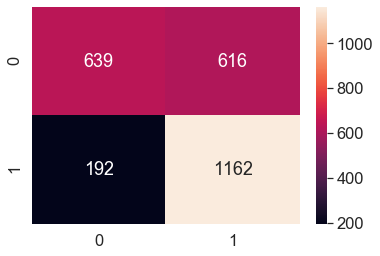

In [52]:
gb_model_disc = GradientBoostingClassifier(random_state=9005,
                                          learning_rate =  0.01,
                                           max_depth = 3,
                                           n_estimators = 250)
predict_evaluate_model_v2(gb_model_disc, X_train, y_train, X_test, y_test, 'discount', True, True)

The optimum parameters for the model were 'learning rate': 0.01,'max depth': 3, and 'n estimators': 250 after hyper parameter adjustment. Train and test sets were closer to 69 percent accurate, with train and test Fscores of 71 percent and 61 percent, respectively. More pruning of the model could improve these even more.

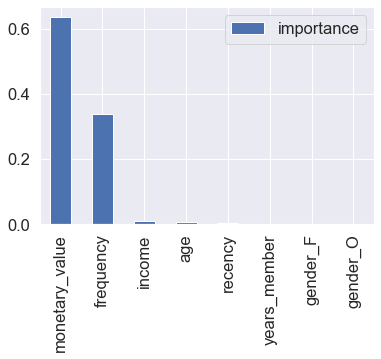

,importance
monetary_value,0.635448
frequency,0.337499
income,0.010556
age,0.007370
recency,0.005202
years_member,0.002260
gender_F,0.001308
gender_O,0.000357


In [53]:
get_feature_importance(gb_model_disc, x, plot= True)

The success rate of Discount offers seems to be affected by RFM features, income, age, membership period and age. Customers' spending and frequency of visits appear to be the most essential factors among them, similar to BOGO disocunts.

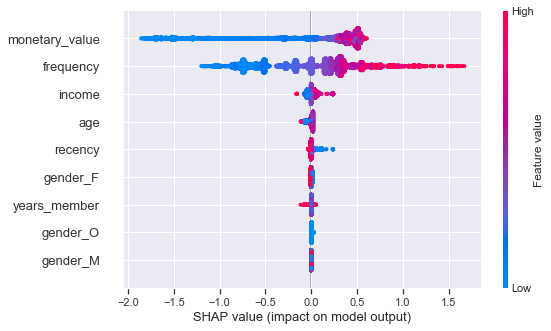

In [54]:
clf_disc = gb_model_disc.fit(X_train, y_train)
X_train_df_disc = pd.DataFrame(X_train, columns = x.columns)
explainer_disc = shap.TreeExplainer(clf_disc)
shap_values_disc = explainer_disc.shap_values(X_train_df_disc)
shap.summary_plot(shap_values_disc, features=X_train_df_disc, feature_names=X_train_df_disc.columns)

### 6. Discussion and Conclusion

It was discovered that high-spending, high-frequent customers who have been with Starbucks for a long time were more successful in BOGO discounts, whereas high-spending, high-frequent customers with a high income range appear to be more effective in discount offers.

Possible enhancements
- More features could have been developed
- RFM features could have been grouped together with weights and created RFM clusters using domain knowledge
- More model pruning could have occurred,
- FLASK web application for Starbucks could have been developed to query usergroups for a specific offers, making the implementation easier.